## word2vec
##### 単語をベクトルで表現する表現は二つある。
* カウントベース
* 推論ベース

#### カウントベース手法の問題点
* コーパス全体の統計データをしようしているので、大規模なコーパスを扱う際に学習に時間がかかってしまう。

#### 推論ベース手法
* ニューラルネットワークでミニバッチを使用する。
* 出現しうる単語を推測する。（確率分布を使用したりして）
* one-hot表現（０か１）で表す。（単語IDの該当する箇所を１、それ以外を０にする）

In [1]:
import numpy as np
import os
os.chdir("/work/NaturalProcessing/deep-learning-from-scratch-2-master")

In [2]:
from common.layers import MatMul
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[0.07977711 1.46044307 0.97237049]]


### word２vecの実装
* **CBOW(continuous bag-of-words)**と呼ばれるモデルを使用する
* コンテキストからターゲットを推測することをを目的としたニューラルネットワーク
##### 流れ
* 入力層→重みの設定→順伝播→softmax with Loss(softmaxレイヤと交差エントロピーーレイヤの融合版)

In [3]:
#サンプルのコンテキストデータ（入力層が複雑になる）
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

#重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

#レイヤの作成（それぞれの層で重みを共有）
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#順伝播（活性化関数を使用しない）
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[ 1.38733115  2.36921216  1.13546705  0.23695235 -1.48230638 -1.46742554
   0.36939891]]


In [4]:
from common.util import preprocess
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [5]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [6]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print("target:", target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
target: [1 2 3 4 1 5]


In [7]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    return one_hot

In [8]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [9]:
from common.layers import MatMul, SoftmaxWithLoss

In [11]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        #重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype("f")
        W_out = 0.01 * np.random.randn(H, V).astype("f")
        
        #レイヤの作成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        #重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        #メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        ds *= 0.5
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)
        return None

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

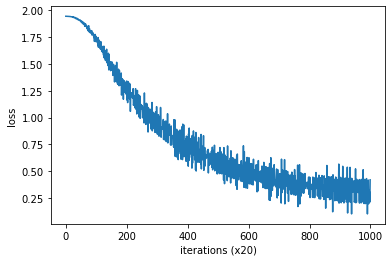

In [12]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [13]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.92318064 -1.049705    0.8848261   1.0360849  -1.6890339 ]
say [ 0.51540333  1.2550353  -0.42601255 -1.2706144  -1.218417  ]
goodbye [-0.91973984 -1.0334233   0.95882046  1.0531093   0.6787607 ]
and [ 1.6083705   0.7636977  -1.6035379  -0.76290023 -1.1374232 ]
i [-0.9199484 -1.0364265  0.9718163  1.0550597  0.6841823]
hello [-0.93752444 -1.0415276   0.9049985   1.0681461  -1.6890898 ]
. [-1.6062853   1.273634    1.5601251  -1.2711889  -0.95682925]


### 確率の視点から見たCBOWモデル
* 同時確率は次のように表すことができる**P(A, B)**
* 事後確率は次のように表すことができる**P(A|B)**（Bという情報が与えられた時のAが起こる確率）

#### CBOWモデルの確率
$$P(w_t|w_{t-1}, w_{t+1})$$

* w_t-1とw_t+1が起こった後に、w_tが起こる確率を表している。
* ここに交差エントロピー誤差を当てはめる

$$L=-\sum_k t_k\log{y_k}$$
$$L=-\log{P(w_t|w_{t-1}, w_{t+1})}$$

* 上記の式は負の対数尤度と呼ばれる。全体に拡張すると、損失関数は次のように表現できる。
$$L=-\frac{1}{T}\sum_{t=1}^T\log{P(w_t|w_{t-1}, w_{t+1})}$$

### skip-gramモデル
* CBOWモデルはコンテキストが複数あり、その複数のコンテキストから中央の単語を推測。
* 中央の単語から周囲の複数ある単語を推測する。

$$P(w_{t-1}, w_{t+1}|w_t)$$
* w_tが与られたときw_t-1とw_t+1が同時に起こる確率。また単語間に関連性がないと仮定するならば次のように分解します。
$$P(w_{t-1}, w_{t+1}|w_t)=P(w_{t-1}|w_t)P(w_{t+1}|w_t)$$
* 損失関数は次のように表現できます。
$$L=-\frac{1}{T}\sum_{t=1}^T\log{P(w_{t-1}|w_t)}+\log{P(w_{t+1}|w_t)}$$

In [14]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None
